In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.parametrizations import spectral_norm
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = '/content/drive/MyDrive/Colab/lab/GAN/data/'


Mounted at /content/drive


In [ ]:
# choose data file
datafile = 'data'

if not os.path.exists('/content/Images'):
    with zipfile.ZipFile(data_path + datafile + '.zip', "r") as zip_ref:
        zip_ref.extractall()

print('Done')


Done


# 0. Load data

In [ ]:
df = pd.read_csv(data_path + datafile + '.csv')
df.head()


,Image_name,Brain_plane
0,Patient00168_Plane3_1_of_3,0
1,Patient00168_Plane3_2_of_3,0
2,Patient00168_Plane3_3_of_3,1
3,Patient00188_Plane3_1_of_3,0
4,Patient00188_Plane3_2_of_3,2


In [ ]:
labels_dict = {
    'Trans-thalamic': 0,
    'Trans-cerebellum': 1,
    'Trans-ventricular': 2
}


In [ ]:
df = df[df['Brain_plane']==0]
df.shape


(1432, 2)

# 1. Prepare Image Dataset

In [ ]:
# image_paths = [f'Images/{i}.png' for i in df['Image_name'].values]
# image_data = torch.cat([transforms(Image.open(i)) for i in image_paths])
# torch.mean(image_data), torch.std(image_data)


In [ ]:
# Apply transformation
transforms = Compose([
    Resize((128, 128)),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize([0.5], [0.5])    # ([0~1] - 0.5) / 0.5
])


In [ ]:
class ImageDataset(Dataset):
    """
    A customized dataset class that loads images from folder from pytorch.
    args:
    - df: pre-processed dataframe
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self,
                 df,
                 transforms=None,
                 directory='Images/',
                 extension='.png'):
        self.img_labels = df
        self.transforms = transforms
        self.directory = directory
        self.extension = extension

    def __len__(self):
        """ returns the number of items in the dataset """
        return self.img_labels.shape[0]

    def __getitem__(self, idx):
        """ load an image and apply transformation """
        image_path = os.path.join(
            self.directory,
            self.img_labels.iloc[idx, 0] + self.extension)
        image = Image.open(image_path)
        if self.transforms:
            image = self.transforms(image)
        return image


In [ ]:
def denormalize(image):
    return ((image + 1.) / 2. * 255).type(torch.uint8)


In [ ]:
training_data = ImageDataset(df, transforms)


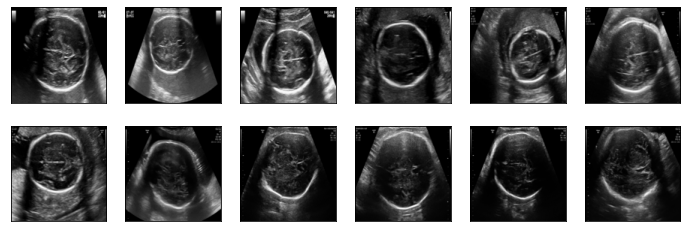

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(12, 4))
plot_size=12
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    # ax.title.set_text(labels)
    img = denormalize(training_data[idx][0]).squeeze().numpy()
    ax.imshow(img, cmap='gray')

plt.show()
plt.clf()


# 2. Model Implementation

output size = [(W−K+2P)/S]+1

W - input volume<br>
K - kernel size<br>
P - padding<br>
S - stride<br>

## Attention

In [ ]:
class Self_Attn_block(nn.Module):
    # scaled dot product attention
    # arxiv.org/abs/1805.08318
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels
        self.f = nn.Conv2d(self.in_channels, self.in_channels//8, 1, stride=1, padding=0, bias=False)
        self.g = nn.Conv2d(self.in_channels, self.in_channels//8, 1, stride=1, padding=0, bias=False)
        self.h = nn.Conv2d(self.in_channels, self.in_channels//2, 1, stride=1, padding=0, bias=False)
        self.attn_out = nn.Conv2d(self.in_channels//2, self.in_channels, 1, stride=1, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        b, c, h, w = x.size()
        f_x = self.f(x).view(b, -1, h*w)
        g_x = self.g(x).view(b, -1, h*w)

        attn = torch.bmm(f_x.permute(0, 2, 1), g_x) # b, h*w, h*w
        attn = self.softmax(attn)

        h_x = self.h(x).view(b, -1, h*w) # b, c/2, h*w

        out = torch.bmm(h_x, attn.permute(0, 2, 1)) # b, c/2, h*w
        out = out.view(b, -1, h, w)
        out = self.attn_out(out) # b, c, h, w

        out = x + self.sigma*out
        return out


## Generator

In [ ]:
class GeneratorBlock(nn.Module):
    # upsample x2
    def __init__(self, in_channels, out_channels, upsample=True):
        super().__init__()
        self.upsample = upsample
        self.conv = nn.Sequential(
            spectral_norm(nn.Conv2d(
                in_channels, out_channels, 3, stride=1, padding=1, bias=False)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            spectral_norm(nn.Conv2d(
                out_channels, out_channels, 3, stride=1, padding=1, bias=False)),
            nn.BatchNorm2d(out_channels)
        )

        self.res = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False)
        )

        if self.upsample:
            self.conv = nn.Sequential(
                nn.Upsample(scale_factor=2),
                self.conv
            )
            self.res = nn.Sequential(
                nn.Upsample(scale_factor=2),
                self.res
            )

    def layer_summary(self, X_shape):
        X = torch.randn(X_shape)
        for layer in self.conv:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

    def forward(self, x):
        y = self.conv(x)
        y += self.res(x)
        return F.relu(y)


In [ ]:
net = GeneratorBlock(128, 64)
net.layer_summary(((16, 128, 1, 1)))


Upsample output shape:	 torch.Size([16, 128, 2, 2])
Sequential output shape:	 torch.Size([16, 64, 2, 2])


In [ ]:
class Generator(nn.Module):
    """ Self attention generator with residuals and spectral norms """
    def __init__(self, latent_dim, img_size, n_channel):
        super().__init__()
        self.img_size = img_size
        self.channel = n_channel
        self.convT = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(latent_dim, self.channel*16, 4, stride=1, padding=0, bias=False)), # 512 x 4 x 4
            nn.BatchNorm2d(self.channel*16),
            nn.ReLU(),
            GeneratorBlock(self.channel*16, self.channel*16), # 512 x 8 x 8
            GeneratorBlock(self.channel*16, self.channel*8), # 256 x 16 x 16
            GeneratorBlock(self.channel*8, self.channel*4), # 128 x 32 x 32
            Self_Attn_block(self.channel*4),
            GeneratorBlock(self.channel*4, self.channel*4, upsample=False),
            GeneratorBlock(self.channel*4, self.channel*2), # 64 x 64 x 64
            GeneratorBlock(self.channel*2, self.channel), # 32 x 128 x 128
            spectral_norm(nn.Conv2d(self.channel, 1, 3, stride=1, padding=1, bias=False)), # 1 x 128 x 128
            nn.Tanh()
        )

    def layer_summary(self, X_shape):
        X = torch.randn(X_shape)
        for layer in self.convT:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

    def forward(self, x):
        x = self.convT(x)
        return x


In [ ]:
net = Generator(128, 128, 64)
net.layer_summary(((16, 128, 1, 1)))


ParametrizedConvTranspose2d output shape:	 torch.Size([16, 1024, 4, 4])
BatchNorm2d output shape:	 torch.Size([16, 1024, 4, 4])
ReLU output shape:	 torch.Size([16, 1024, 4, 4])
GeneratorBlock output shape:	 torch.Size([16, 1024, 8, 8])
GeneratorBlock output shape:	 torch.Size([16, 512, 16, 16])
GeneratorBlock output shape:	 torch.Size([16, 256, 32, 32])
Self_Attn_block output shape:	 torch.Size([16, 256, 32, 32])
GeneratorBlock output shape:	 torch.Size([16, 256, 32, 32])
GeneratorBlock output shape:	 torch.Size([16, 128, 64, 64])
GeneratorBlock output shape:	 torch.Size([16, 64, 128, 128])
ParametrizedConv2d output shape:	 torch.Size([16, 1, 128, 128])
Tanh output shape:	 torch.Size([16, 1, 128, 128])


## Discriminator

In [ ]:
# class DiscriminatorBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, downsample=True, res=True):
#         super().__init__()
#         self.downsample = downsample
#         self.res = res
#         self.conv = nn.Sequential(
#             spectral_norm(nn.Conv2d(
#                 in_channels, out_channels, 3, stride=1, padding=1, bias=False)),
#             # nn.BatchNorm2d(out_channels),
#             nn.ReLU(),
#             spectral_norm(nn.Conv2d(
#                 out_channels, out_channels, 3, stride=1, padding=1, bias=False)),
#             # nn.BatchNorm2d(out_channels)
#         )

#         self.res = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False)
#         )

#         if self.downsample:
#             self.conv = nn.Sequential(
#                 nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
#                 self.conv
#             )
#             self.res = nn.Sequential(
#                 nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
#                 self.res
#             )

#     def layer_summary(self, X_shape):
#         X = torch.randn(X_shape)
#         for layer in self.conv:
#             X = layer(X)
#             print(layer.__class__.__name__, 'output shape:\t', X.shape)

#     def forward(self, x):
#         y = self.conv(x)
#         if self.res:
#             y += self.res(x)
#         return F.relu(y)


In [ ]:
# net = DiscriminatorBlock(1, 32)
# net.layer_summary(((16, 1, 128, 128)))


MaxPool2d output shape:	 torch.Size([16, 1, 64, 64])
Sequential output shape:	 torch.Size([16, 32, 64, 64])


In [ ]:
class Discriminator(nn.Module):
    """ normal conv2d discriminator with spectral norms and without self attention 
    
    
    
    """
    def __init__(self, img_size, n_channel):
        super().__init__()
        self.img_size = img_size
        self.channel = n_channel
        self.conv = nn.Sequential(
            spectral_norm(nn.Conv2d(1, self.channel, 4, stride=2, padding=1, bias=False)), # 32 x 64 x 64
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(self.channel, self.channel*2, 4, stride=2, padding=1, bias=False)), # 64 x 32 x 32
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(self.channel*2, self.channel*4, 4, stride=2, padding=1, bias=False)), # 128 x 16 x 16
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(self.channel*4, self.channel*8, 4, stride=2, padding=1, bias=False)), # 256 x 8 x 8
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(self.channel*8, self.channel*16, 4, stride=2, padding=1, bias=False)), # 512 x 4 x 4
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(self.channel*16, 1, 4, stride=1, padding=0, bias=False)), # 1 x 1 x 1
        )

    def layer_summary(self, X_shape):
        X = torch.randn(X_shape)
        for layer in self.conv:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

    def forward(self, img):
        x = self.conv(img)
        return x


In [ ]:
    # made discriminator too good...archived
    # def __init__(self, img_size, n_channel):
    #     super().__init__()
    #     self.img_size = img_size
    #     # self.label_embed = nn.Embedding(3, img_size * img_size)
    #     self.channel = n_channel
    #     self.conv = nn.Sequential(
    #         DiscriminatorBlock(1, self.channel, res=False), # 32 x 64 x 64
    #         DiscriminatorBlock(self.channel, self.channel*2), # 64 x 32 x 32
    #         DiscriminatorBlock(self.channel*2, self.channel*4), # 256 x 16 x 16
    #         # self attention block
    #         Self_Attn_block(self.channel*4),
    #         DiscriminatorBlock(self.channel*4, self.channel*8), # 512 x 8 x 8
    #         DiscriminatorBlock(self.channel*8, self.channel*16),
    #         spectral_norm(nn.Conv2d(self.channel*16, 1, 4, stride=1, padding=0, bias=False)), # 1 x 1 x 1
    #     )

In [ ]:
net = Discriminator(128, 64)
net.layer_summary(((16, 1, 128, 128)))


ParametrizedConv2d output shape:	 torch.Size([16, 64, 64, 64])
LeakyReLU output shape:	 torch.Size([16, 64, 64, 64])
ParametrizedConv2d output shape:	 torch.Size([16, 128, 32, 32])
LeakyReLU output shape:	 torch.Size([16, 128, 32, 32])
ParametrizedConv2d output shape:	 torch.Size([16, 256, 16, 16])
LeakyReLU output shape:	 torch.Size([16, 256, 16, 16])
ParametrizedConv2d output shape:	 torch.Size([16, 512, 8, 8])
LeakyReLU output shape:	 torch.Size([16, 512, 8, 8])
ParametrizedConv2d output shape:	 torch.Size([16, 1024, 4, 4])
LeakyReLU output shape:	 torch.Size([16, 1024, 4, 4])
ParametrizedConv2d output shape:	 torch.Size([16, 1, 1, 1])


## Weights

In [ ]:
def weights_init(module):
    """Initialize weights for discriminator"""
    if type(module) in [nn.Conv2d, nn.ConvTranspose2d]:
        nn.init.xavier_uniform_(module.weight)


# 3. Loss

In [ ]:
def generator_loss(fake_logits):
    """ hinge loss """
    return -fake_logits.mean()


In [ ]:
def discriminator_loss(real_logits, fake_logits):
    """ hinge loss """

    r_loss = nn.ReLU()(1.0 - real_logits).mean()
    f_loss = nn.ReLU()(1.0 + fake_logits).mean()

    d_loss = r_loss + f_loss
    return d_loss


# 4. Single Training Step

In [ ]:
def generator_step(batch_size, latent_dim):
    """ One training step of the generator. """
    g_optimizer.zero_grad()

    latent = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    latent = torch.from_numpy(latent).float().requires_grad_(False).to(device)

    fake_images = generator(latent)
    d_fake = discriminator(fake_images)
    g_loss = generator_loss(d_fake)
    g_loss.backward()
    g_optimizer.step()
    return {'loss': g_loss}


def discriminator_step(batch_size, latent_dim, real_images):
    """ One training step of the discriminator. """
    d_optimizer.zero_grad()
    d_real = discriminator(real_images)

    latent = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    latent = torch.from_numpy(latent).float().requires_grad_(False).to(device)

    fake_images = generator(latent)
    d_fake = discriminator(fake_images.detach())
    d_loss = discriminator_loss(d_real, d_fake)
    d_loss.backward()
    d_optimizer.step()
    
    return {'loss': d_loss}


In [ ]:
latent_dim = 128
img_size = 128
n_channel = 32
n_epochs = 100
batch_size = 64
d_lr = 0.0004
g_lr = 0.0001
beta1 = 0.5
beta2 = 0.999
print_every = 15


In [ ]:
train_dataloader = DataLoader(training_data, batch_size, num_workers=2, shuffle=True)
discriminator = Discriminator(img_size, n_channel).to(device)
discriminator.apply(weights_init)
generator = Generator(latent_dim, img_size, n_channel).to(device)
generator.apply(weights_init)

d_optimizer = torch.optim.Adam(discriminator.parameters(), d_lr, [beta1, beta2])
g_optimizer = torch.optim.Adam(generator.parameters(), g_lr, [beta1, beta2])


In [ ]:
def display(generated_images):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(12, 4))
    plot_size = 12
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = denormalize(generated_images[idx]).squeeze().detach().cpu().numpy()
        ax.imshow(img, cmap='gray')
    plt.show()
    plt.clf()


In [ ]:
# Load previous model if needed

# discriminator.load_state_dict(torch.load(data_path+'discriminator_100.pt'))
# generator.load_state_dict(torch.load(data_path+'generator_100.pt'))


In [ ]:
fixed_latent_vector = torch.ones((12, latent_dim, 1, 1)).uniform_(-1, 1).float().to(device)

losses = []
discriminator.train()
generator.train()

# n_epochs
for epoch in range(n_epochs):
    for i, real_images in enumerate(train_dataloader):
        real_images = real_images.to(device)

        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        g_loss = generator_step(batch_size, latent_dim)

        if i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))

            # print discriminator and generator loss
            print(f'Epoch [{epoch+1}/{n_epochs}] | Batch {i}/{len(train_dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')

    if (epoch+1) % 5 == 0:
        # display images during training
        generator.eval()
        generated_images = generator(fixed_latent_vector)
        display(generated_images)
        generator.train()


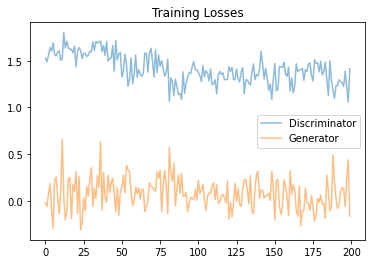

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()


In [ ]:
torch.save(discriminator.state_dict(), data_path+'discriminator_res_sa_300.pt')
torch.save(generator.state_dict(), data_path+'generator_res_sa_300.pt')


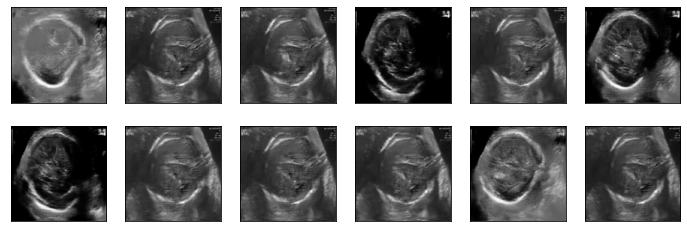

<Figure size 432x288 with 0 Axes>

In [ ]:
fixed_latent_vector_0 = torch.randn(12, latent_dim, 1, 1).float().to(device)
generator.eval()
generated_images = generator(fixed_latent_vector_0)
display(generated_images)


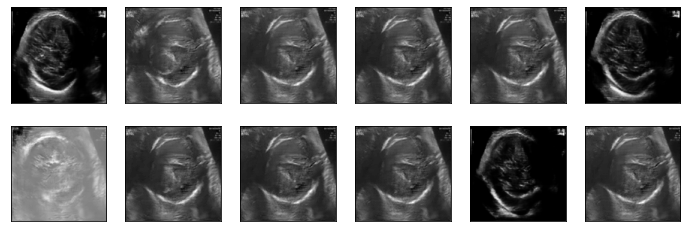

<Figure size 432x288 with 0 Axes>

In [ ]:
fixed_latent_vector_1 = torch.ones((12, latent_dim, 1, 1)).uniform_(-1, 1).float().to(device)

generator.eval()
generated_images = generator(fixed_latent_vector_1)
display(generated_images)


In [ ]:
def display_single(generated_images):
    """ helper function to display images during training """
    img = denormalize(generated_images.squeeze()).detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()
    plt.clf()


In [ ]:
generator.eval()
latent_a = torch.ones((1, latent_dim, 1, 1)).uniform_(-1, 1).float().to(device)
generated_images_a = generator(latent_a)


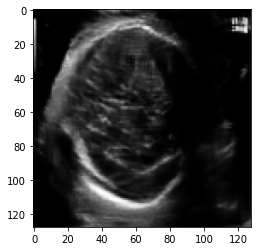

<Figure size 432x288 with 0 Axes>

In [ ]:
display_single(generated_images_a)


In [ ]:
latent_b = torch.ones((1, latent_dim, 1, 1)).uniform_(-1, 1).float().to(device)
generated_images_b = generator(latent_b)


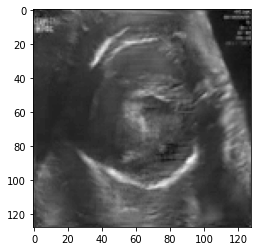

<Figure size 432x288 with 0 Axes>

In [ ]:
display_single(generated_images_b)


In [ ]:
latent_c = torch.ones((1, latent_dim, 1, 1)).uniform_(-1, 1).float().to(device)
generated_images_c = generator(latent_c)


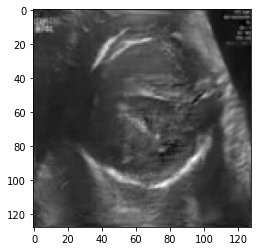

<Figure size 432x288 with 0 Axes>

In [ ]:
display_single(generated_images_c)


In [ ]:
def get_interpolations(m_A, m_B, num_interpolation):
    interpolates = []
    accum = 0
    diff = m_B - m_A
    step = diff / (num_interpolation+1)
    for i in range(num_interpolation):
        interpolated = m_A + step * (i+1)
        interpolates.append(interpolated)
    return interpolates

In [ ]:
def generate_multiples(latent_vector_list):
    return [generator(latent) for latent in latent_vector_list]


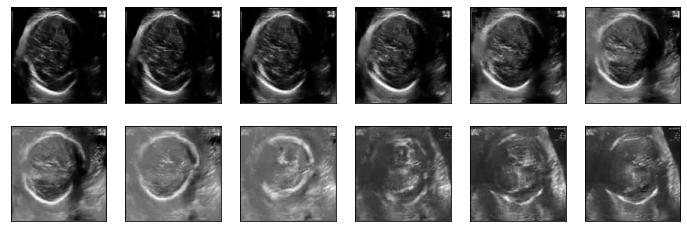

<Figure size 432x288 with 0 Axes>

In [ ]:
interp_a_b = get_interpolations(latent_a, latent_b, 12)
display(generate_multiples(interp_a_b))


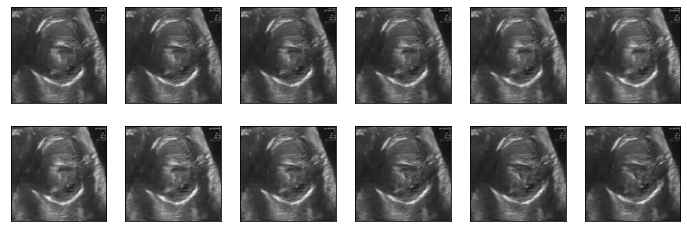

<Figure size 432x288 with 0 Axes>

In [ ]:
interp_b_c = get_interpolations(latent_b, latent_c, 12)
display(generate_multiples(interp_b_c))


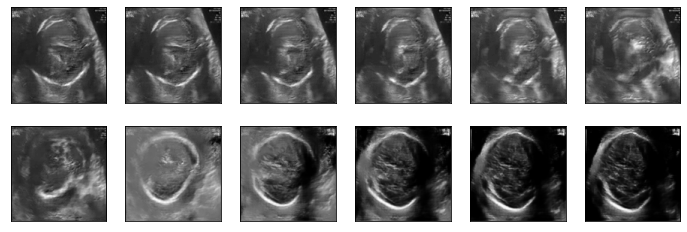

<Figure size 432x288 with 0 Axes>

In [ ]:
interp_c_a = get_interpolations(latent_c, latent_a, 12)
display(generate_multiples(interp_c_a))
